In [1]:
import dynalearn
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import tqdm
import os

In [2]:
def chain_graph(n):
    g = nx.Graph()
    g.add_node(0)
    for i in range(1, n):
        g.add_node(i)
        g.add_edge(i - 1, i)
    g.name = 'chain_n{0}'.format(n)
    return g

def complete_graph(n):
    g = nx.complete_graph(n)
    g.name = 'complete_n{0}'.format(n)
    return g

def star_graph(n):
    g = nx.Graph()
    g.add_node(0)
    for i in range(1, n):
        g.add_edge(0, i)
    g.name = 'star_n{0}'.format(n)
    return g

def regular_graph(n, d):
    g = nx.random_regular_graph(d, n)
    g.name = 'regular_n{0}_d{1}'.format(n, d)
    return g

def show_dataset(dataset):
    avg = []
    for i in range(len(dataset)):
        x = dataset[i][0].numpy()
        avg.append(np.mean(x))
    return avg

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


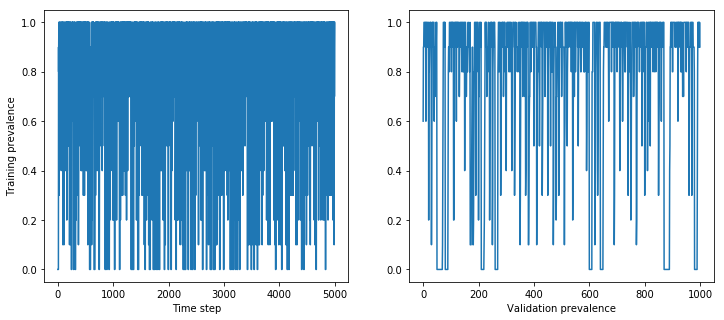

In [3]:
# Generating the network
n_nodes = 10
inf_prob = 0.2
rec_prob = 0.08
T = 10

train_sample = 5000
val_sample = 1000
approach = "nn_completeMethod"

graph = complete_graph(n_nodes)
# graph = chain_graph(n_nodes)
# graph = star_graph(n_nodes)

# Generating the dataset
# transform = [dynalearn.datasets.SIS_StateToNumber(past_format={'S':0, 'I':1}, present_dtype=torch.long)]
train_progress_bar = tqdm.tqdm_notebook(range(train_sample), desc='Training')
val_progress_bar = tqdm.tqdm_notebook(range(val_sample), desc='Validation')

transform = [dynalearn.datasets.SIS_StateToNumber()]

train_dataset = dynalearn.datasets.SISDataset(graph, inf_prob, rec_prob)
val_dataset = dynalearn.datasets.SISDataset(graph, inf_prob, rec_prob)
train_dataset.generate(train_sample, T,
                       init_active=None,
                       transform_input=transform,
                       transform_target=transform,
                       max_null_iter=100,
                       progress_bar=train_progress_bar)
val_dataset.generate(val_sample, T,
                     init_active=None,
                     transform_input=transform,
                     transform_target=transform,
                     max_null_iter=20,
                     progress_bar=val_progress_bar)

train_progress_bar.close()
val_progress_bar.close()
f_prefix = 'data/' + approach + "_" + graph.name + "_SIS_inf{0}_rec{1}".format(inf_prob, rec_prob)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
train_avg = show_dataset(train_dataset)
val_avg = show_dataset(val_dataset)
ax[0].plot(train_avg)
ax[0].set_xlabel('Time step')
ax[0].set_ylabel('Training prevalence')
ax[1].plot(val_avg)
ax[1].set_xlabel('Time step')
ax[1].set_xlabel('Validation prevalence')
plt.show()

In [4]:
n_hidden = [128, 128]
lr = 1e-2
wd = 1e-3
use_cuda = torch.cuda.is_available()

model = dynalearn.models.neural_net.basicCompleteMarkovNN(graph, n_hidden)


In [5]:
optimizer = lambda p: torch.optim.Adam(p, lr=lr, weight_decay=wd)
# optimizer = lambda p: torch.optim.SGD(p, lr=lr, weight_decay=wd)
loss = torch.nn.BCELoss(reduction='none')
scheduler = lambda o: torch.optim.lr_scheduler.ReduceLROnPlateau(o, patience=5, factor=0.2)

model.compile(optimizer, loss, scheduler)

In [6]:
model.fit(train_dataset,
#           val_dataset=val_dataset,
          epochs=20,
          batch_size=128,
          verbose=True,
          keep_best=True,
          training_metrics=['loss'],
          model_metrics=['lr'],
          show_var=False)

New best Epoch: 0 - Time: 0.00
	 Train. - loss: 0.6938, 
New best Epoch: 1 - Time: 0.37, lr: 0.01
	 Train. - loss: 0.2817, 
Epoch: 2 - Time: 0.24, lr: 0.01
New best Epoch: 3 - Time: 0.24, lr: 0.01
	 Train. - loss: 0.2197, 
New best Epoch: 4 - Time: 0.24, lr: 0.01
	 Train. - loss: 0.2039, 
Epoch: 5 - Time: 0.24, lr: 0.01
Epoch: 6 - Time: 0.24, lr: 0.01
Epoch: 7 - Time: 0.25, lr: 0.01
Epoch: 8 - Time: 0.24, lr: 0.01
New best Epoch: 9 - Time: 0.28, lr: 0.01
	 Train. - loss: 0.1945, 
New best Epoch: 10 - Time: 0.24, lr: 0.01
	 Train. - loss: 0.1922, 
Epoch: 11 - Time: 0.22, lr: 0.01
Epoch: 12 - Time: 0.23, lr: 0.01
Epoch: 13 - Time: 0.23, lr: 0.01
Epoch: 14 - Time: 0.25, lr: 0.01
New best Epoch: 15 - Time: 0.25, lr: 0.01
	 Train. - loss: 0.1894, 
Epoch: 16 - Time: 0.22, lr: 0.01
New best Epoch: 17 - Time: 0.25, lr: 0.01
	 Train. - loss: 0.1879, 
New best Epoch: 18 - Time: 0.25, lr: 0.01
	 Train. - loss: 0.1876, 
New best Epoch: 19 - Time: 0.25, lr: 0.01
	 Train. - loss: 0.1875, 
New best E

In [7]:
model.save_state(f_prefix)

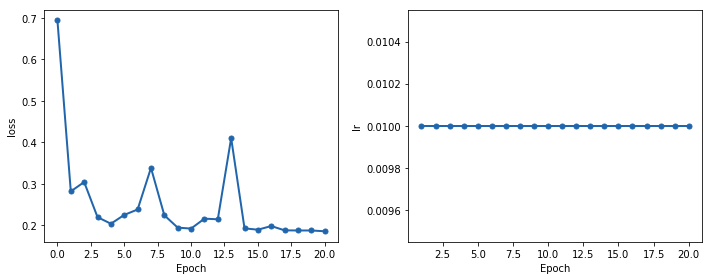

In [8]:
fig, ax = plt.subplots(1, 2,figsize=(10, 4))
_ax = {}
metrics = ['loss', 'lr']
for i, m in enumerate(metrics):
#     ax[i].set_xscale('log')
#     ax[i].set_yscale('log')
    _ax[m] = ax[i]

model.history.plot(training_metrics = ['loss'], model_metrics=['lr'],ax=(fig,_ax))
plt.tight_layout()

fig.savefig(os.path.join(f_prefix, 'training.png'))
plt.show()

In [8]:
def get_transitionProb(graph, model, dataset, epsilon=None):
    all_states = dataset.enumerate_all_states(graph)
    
    realTransProb = np.zeros([len(all_states), len(all_states)])
    learnedTransProb = np.zeros([len(all_states), len(all_states)])
    bar = tqdm.tqdm_notebook(range(len(all_states)), desc='Evaluation')
    for j, past in enumerate(all_states):
        bar.update()
        _past = torch.tensor(past).float()
#         _past = _past.view(1, n_nodes, 1)

        realProb = dataset.get_transition_probability(graph, past)
        learnedProb = model.predict(_past, dataset.adjacency, batch_size=1).numpy()
        
        
        for i, present in enumerate(all_states):
            present_real_prob = present * realProb + (1 - present) * (1 - realProb)
            present_learned_prob = present * learnedProb + (1 - present) * (1 - learnedProb)
            realTransProb[i, j] = np.prod(present_real_prob)
            learnedTransProb[i, j] = np.prod(present_learned_prob)
    
    if epsilon:
        realTransProb[realTransProb == 0] = epsilon
        learnedTransProb[learnedTransProb == 0] = epsilon
    
    for i in range(len(all_states)):
        if realTransProb[:, i].sum() > epsilon * len(all_states) * 2:
            realTransProb[:, i] /= realTransProb[:, i].sum()
        
        if learnedTransProb[:, i].sum() > epsilon * len(all_states) * 2:
            learnedTransProb[:, i] /= learnedTransProb[:, i].sum()
    
    return realTransProb, learnedTransProb


def bit_to_value(array):
    d = array.shape
    bit = 2**np.arange(d)
    return np.sum(array * bit)

def bit_to_value_torch(array):
    d = array.size(0)
    bit = 2**torch.arange(d, dtype=array.dtype)
    return int(torch.sum(array * bit))
    

def get_transitionOccurence(graph, dataset, epsilon=None):
    all_states = dataset.enumerate_all_states(graph)
    n = graph.number_of_nodes()
    occurence = np.zeros([2**n, 2**n])
    bar = tqdm.tqdm_notebook(range(len(dataset)), desc='Occurence')
    
    for i in range(len(dataset)):
        bar.update()
        inputs, adj, targets = dataset[i]
        inputs = inputs.clone().squeeze()
        targets = targets.clone().squeeze()
        i, j = bit_to_value_torch(targets), bit_to_value_torch(inputs)
        
        occurence[i, j] += 1
    
    if epsilon:
        occurence[occurence == 0] = epsilon
    
    return occurence / np.sum(occurence)
    
    
    
        

In [9]:
# realTransProb, learnedTransProb = get_transitionProb(graph, model, train_dataset, epsilon=1e-50)
occurence = get_transitionOccurence(graph, train_dataset, epsilon=1e-50)

# np.savetxt(os.path.join(f_prefix, "real_transition_prob.txt"), realTransProb)
# np.savetxt(os.path.join(f_prefix, "learned_transition_prob.txt"), learnedTransProb)
np.savetxt(os.path.join(f_prefix, "config_occurence.txt"), occurence)

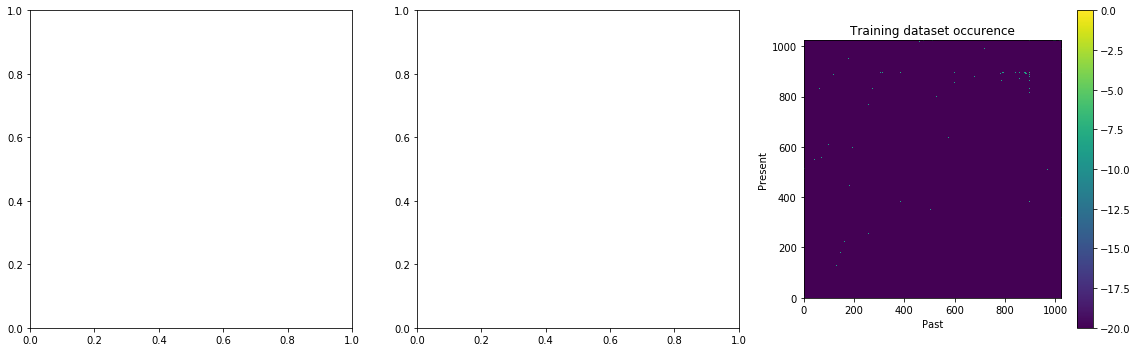

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

# cs = ax[0].imshow(np.log(realTransProb), origin='lower', vmin=-20, vmax=0)
# # ax[0].xaxis.tick_top()
# ax[0].set_xlabel('Past')
# ax[0].set_ylabel('Present')
# ax[0].set_title('Real dynamics')
# plt.colorbar(cs, ax=ax[0])

# ax[1].imshow(np.log(learnedTransProb), origin='lower', vmin=-20, vmax=0)
# # ax[1].xaxis.tick_top()
# ax[1].set_xlabel('Past')
# ax[1].set_ylabel('Present')
# ax[1].set_title('Learned model')
# plt.colorbar(cs, ax=ax[1])

cs = ax[2].imshow(np.log(occurence), origin='lower', vmin=-20, vmax=0)
ax[2].set_xlabel('Past')
ax[2].set_ylabel('Present')
ax[2].set_title('Training dataset occurence')
plt.colorbar(cs, ax=ax[2])
plt.tight_layout()

fig.savefig(os.path.join(f_prefix, "transition_prob.png"))

plt.show()

In [14]:
n, m = occurence.shape
data_real = []
data_learned = []
notdata_real = []
notdata_learned = []


for i in range(n):
    for j in range(n):    
        if occurence[i, j] > 1e-15:
            data_real.append(realTransProb[i, j])
            data_learned.append(learnedTransProb[i, j])
        else:
            notdata_real.append(realTransProb[i, j])
            notdata_learned.append(learnedTransProb[i, j])
            

/home/charles/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)
/home/charles/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1479: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


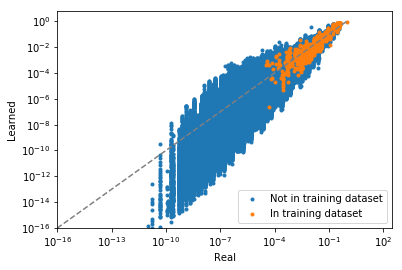

In [15]:
plt.plot(notdata_real, notdata_learned, '.', label='Not in training dataset')
plt.plot(data_real, data_learned, '.', label='In training dataset')
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), c='grey', ls='--')
plt.xlabel('Real')
plt.ylabel('Learned')
plt.xscale('log')
plt.yscale('log')
plt.xlim([1e-16, 0])
plt.ylim([1e-16, 0])
plt.legend()
plt.savefig('./testing_probability_20epoch.png')
plt.show()